## 1. Hidden Markov Model (HMM)

Let $Z_t$ be the hidden state at time $t$ where $Z_t \in \{0,1,\dots,K-1\}$, and let $X_t$ be the observed feature vector.

1. **Transition (Markov property)**  
$$
P(Z_t=j\mid Z_{t-1}=i)=A_{ij},\qquad
A=\begin{bmatrix}
a_{0,0}&\cdots&a_{0,K-1}\\
\vdots&\ddots&\vdots\\
a_{K-1,0}&\cdots&a_{K-1,K-1}
\end{bmatrix}.
$$

2. **Emission (Gaussian observation model)**  
$$
P(X_t\mid Z_t=k)=\mathcal N(X_t\mid \mu_k,\Sigma_k).
$$

3. **Initial distribution (stationary)**  
$$
\pi=
\begin{bmatrix}
\pi_0\\
\vdots\\
\pi_{K-1}
\end{bmatrix},
\qquad
\pi=A^\top \pi,
\qquad
\sum_{k=0}^{K-1}\pi_k=1.
$$

4. **Joint probability**
$$
\begin{aligned}
P(X_{1:T},Z_{1:T})
&=
\underbrace{P(Z_1)}_{\pi_{Z_1}}
\cdot
\underbrace{P(X_1 \mid Z_1)}_{\text{Emission at } t=1}
\cdot
\prod_{t=2}^{T}
\underbrace{P(Z_t \mid Z_{t-1})}_{A_{Z_{t-1}, Z_t}}
\cdot
\underbrace{P(X_t \mid Z_t)}_{\text{Emission at } t}
\\
&=
\pi_{Z_1}\,P(X_1\mid Z_1)\,
\prod_{t=2}^{T} A_{Z_{t-1},Z_t}\,P(X_t\mid Z_t).
\end{aligned}
$$


---

### Learning & Inference

#### Goal 1: Learn parameters $\theta=\{\pi,A,\mu_k,\Sigma_k\}$

We maximize the data likelihood:
$$
\hat\theta=\arg\max_{\theta} P(X_{1:T}\mid \theta)
=
\arg\max_{\theta}\sum_{Z_{1:T}} P(X_{1:T},Z_{1:T}\mid \theta).
$$
Solved by **Baum–Welch (EM)**.

**EM idea**  
E-step: compute how likely each state/transition was.  
M-step: update parameters using those likelihood weights.

**Model**
$$
P(X_{1:T},Z_{1:T}\mid\theta)
=
\pi_{Z_1}\prod_{t=2}^{T}A_{Z_{t-1},Z_t}\prod_{t=1}^{T}b_{Z_t}(X_t),
\qquad
b_k(x)=\mathcal N(x\mid\mu_k,\Sigma_k).
$$

**E-step (forward–backward)**
$$
\alpha_1(k)=\pi_k b_k(X_1),\qquad
\alpha_{t+1}(j)=\Big(\sum_{i=0}^{K-1}\alpha_t(i)A_{ij}\Big)\,b_j(X_{t+1}).
$$
$$
\beta_T(k)=1,\qquad
\beta_t(i)=\sum_{j=0}^{K-1}A_{ij}\,b_j(X_{t+1})\,\beta_{t+1}(j).
$$
$$
\gamma_t(k)=P(Z_t=k\mid X_{1:T})
=
\frac{\alpha_t(k)\beta_t(k)}{\sum_{\ell=0}^{K-1}\alpha_t(\ell)\beta_t(\ell)}.
$$
$$
\xi_t(i,j)=P(Z_t=i,Z_{t+1}=j\mid X_{1:T})
=
\frac{\alpha_t(i)A_{ij}b_j(X_{t+1})\beta_{t+1}(j)}
{\sum_{p=0}^{K-1}\sum_{q=0}^{K-1}\alpha_t(p)A_{pq}b_q(X_{t+1})\beta_{t+1}(q)}.
$$

**M-step (update rules)**
$$
\pi_k^{new}=\gamma_1(k),
\qquad
A_{ij}^{new}=\frac{\sum_{t=1}^{T-1}\xi_t(i,j)}{\sum_{t=1}^{T-1}\gamma_t(i)}.
$$
$$
\mu_k^{new}=\frac{\sum_{t=1}^{T}\gamma_t(k)X_t}{\sum_{t=1}^{T}\gamma_t(k)}.
$$
$$
\Sigma_k^{new}
=
\frac{\sum_{t=1}^{T}\gamma_t(k)(X_t-\mu_k^{new})(X_t-\mu_k^{new})^\top}
{\sum_{t=1}^{T}\gamma_t(k)}.
$$

---

#### Goal 2: Posterior state probabilities (smoothing)

For each time $\tau$:
$$
\gamma_\tau(k)=P(Z_\tau=k\mid X_{1:T},\hat\theta)
=
\frac{\alpha_\tau(k)\beta_\tau(k)}{\sum_{j=0}^{K-1}\alpha_\tau(j)\beta_\tau(j)}.
$$

**One-step-ahead state probability (used in code)**
$$
P(Z_{T+1}=\cdot\mid X_{1:T},\hat\theta)=\gamma_T^\top A.
$$

---

#### Goal 3: Next-step mean/std and downside risk (matches your code)

We fit the HMM on standardized data $X'$:
$$
X'=\frac{X-m}{s}
\quad\Longleftrightarrow\quad
X=m+sX',
\qquad
m=\texttt{scaler.mean\_},\; s=\texttt{scaler.scale\_}.
$$

If state $k$ has (in standardized space)
$$
X'\mid (Z=k)\sim \mathcal N(\mu_k',(\sigma_k')^2),
$$
then in original units:
$$
\mu_k=m+s\mu_k',
\qquad
\sigma_k=s\sigma_k',
\qquad
\sigma_k'=\sqrt{(\sigma_k')^2}.
$$

**Downside second moment for a Gaussian (threshold $0$)**  
Let $X\sim\mathcal N(\mu,\sigma^2)$ and define
$$
z=\frac{0-\mu}{\sigma}=-\frac{\mu}{\sigma}.
$$
Then
$$
\mathbb E\!\left[X^2\mathbf 1_{\{X<0\}}\right]
=
(\mu^2+\sigma^2)\Phi(z)-\mu\sigma\,\phi(z),
$$
where $\Phi$ is the standard normal CDF and $\phi$ is the PDF.

For each state $k$, define
$$
d_k=(\mu_k^2+\sigma_k^2)\Phi\!\Big(-\frac{\mu_k}{\sigma_k}\Big)
-\mu_k\sigma_k\,\phi\!\Big(-\frac{\mu_k}{\sigma_k}\Big).
$$

**Next-state probabilities**  
If $\mathbf p_t$ is the current state probability row vector, then
$$
\mathbf p_{t+1}=\mathbf p_t A.
$$
(In code this is `next_states_prob`.)

**Expected mean (next step)**
$$
\mathbb E[X_{t+1}\mid X_{1:t}]
=
\sum_{k=0}^{K-1} p_{t+1}(k)\mu_k.
$$

**Expected variance and std (next step)**  
First compute the mixture second moment:
$$
\mathbb E[X_{t+1}^2\mid X_{1:t}]
=
\sum_{k=0}^{K-1} p_{t+1}(k)\big(\sigma_k^2+\mu_k^2\big).
$$
Then
$$
\mathrm{Var}(X_{t+1}\mid X_{1:t})
=
\mathbb E[X_{t+1}^2\mid X_{1:t}]
-
\Big(\mathbb E[X_{t+1}\mid X_{1:t}]\Big)^2,
$$
$$
\mathrm{Std}(X_{t+1}\mid X_{1:t})
=
\sqrt{\max(\mathrm{Var}(\cdot),\varepsilon)}.
$$

**Expected downside deviation (next step, target $0$)**  
Mix the downside second moments:
$$
\mathbb E[X_{t+1}^2\mathbf 1_{\{X_{t+1}<0\}}\mid X_{1:t}]
=
\sum_{k=0}^{K-1} p_{t+1}(k)d_k.
$$
Define downside std:
$$
\mathrm{DownStd}(X_{t+1}\mid X_{1:t})
=
\sqrt{\max\!\Big(\sum_{k=0}^{K-1} p_{t+1}(k)d_k,\varepsilon\Big)}.
$$


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')


def data_preparation(tickers, period="10y", window_size=5, ma_size=20, interval="1d"):
    assets = {}
    assets_oo = {}
    for ticker in tickers:
        assets[ticker]    = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)["Close"]
        assets_oo[ticker] = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)["Close"].pct_change().shift(-1)  # For calculating returns entry position at t
        assets[ticker].columns    = [f"{ticker}_Close"]
        assets_oo[ticker].columns = [f"{ticker}_oo"]
        assets[ticker][f"{ticker}_ret"]           = assets[ticker][f"{ticker}_Close"].pct_change()
        assets[ticker][f"{ticker}_std"]           = assets[ticker][f"{ticker}_ret"].rolling(window=window_size).std()
        assets[ticker][f"{ticker}_ewma_ret"]      = assets[ticker][f"{ticker}_Close"].ewm(span=window_size, adjust=False).mean().pct_change()
        assets[ticker][f"{ticker}_ewma_down_std"] = assets[ticker][f"{ticker}_ewma_ret"].where(assets[ticker][f"{ticker}_ewma_ret"] < 0, 0).rolling(window=ma_size).std()
    rets_oo = pd.concat([assets_oo[ticker] for ticker in tickers], axis=1)
    df = pd.concat([assets[ticker] for ticker in tickers] + [rets_oo], axis=1, join="inner").dropna()
    return df


def num_states_selection(tickers, df, n_states, past_data_size=int(252*3)):
    print(f"Number of states: {n_states}, Number of years data: {int(past_data_size/252)}")
    for ticker in tickers:
        X_raw = df[[f"{ticker}_ewma_ret"]].values[:past_data_size+1]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_raw)
        model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=500, tol=1e-3, min_covar=1e-3).fit(X_train)
        #model = GMMHMM(n_components=n_states, n_mix=2, covariance_type="diag", n_iter=500, tol=1e-3, min_covar=1e-3).fit(X_train)
        aic_score = round(model.aic(X_train), 4)
        bic_score = round(model.bic(X_train), 4)
        print(f"{ticker}: AIC: {aic_score}, BIC:{bic_score}")
    print("\n")


def hmm_weight(tickers, df, n_states=3, past_data_size=int(252*3), accumulation_size=40, gap_prob=0.5, seed=42, n_iters=500, n_restarts=40):
    X_raws, X_raw_ret, X_raw_std, scalers, models, scores, weight = {}, {}, {}, {}, {}, {}, {}
    accumulation_number = 0
    weight_list = np.zeros(shape=(len(df), len(tickers)))
    for ticker in tickers:
        X_raws[ticker] = df[[f"{ticker}_ewma_ret"]].values
        X_raw_ret[ticker] = df[[f"{ticker}_ret"]].values
        X_raw_std[ticker] = df[[f"{ticker}_ewma_down_std"]].values

    for t in range(past_data_size, len(df)):
        sum_scores = 0
        for ticker in tickers:
            X_raw_trains = X_raws[ticker][t-past_data_size+1:t+1]

            # Training Day 
            if accumulation_number == 0: 
                scalers[ticker] = StandardScaler()
                X_trains = scalers[ticker].fit_transform(X_raw_trains)
                hmm_models = [GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=n_iters, tol=1e-3, min_covar=1e-3, random_state=seed+i).fit(X_trains) for i in range(n_restarts)]
                #hmm_models = [GMMHMM(n_components=n_states, n_mix=2, covariance_type="diag", n_iter=100, tol=1e-3, min_covar=1e-3, random_state=seed+i).fit(X_trains) for i in range(n_restarts)]
                models[ticker] = max(hmm_models, key=lambda m: m.score(X_trains))

            # Non-Training Day
            else:
                X_trains = scalers[ticker].transform(X_raw_trains)

            state_posterior_prob = models[ticker].predict_proba(X_trains)
            next_states_prob = state_posterior_prob[-1] @ models[ticker].transmat_

            mean               = scalers[ticker].mean_[0] + scalers[ticker].scale_[0] * models[ticker].means_.ravel()
            std                = scalers[ticker].scale_[0] * np.sqrt(models[ticker].covars_.ravel())
            z                  = -mean / np.maximum(std, 1e-12)
            down_second_moment = (mean**2 + std**2) * norm.cdf(z) - (mean * std) * norm.pdf(z)

            expected_mean_next_state     = float(next_states_prob @ mean)
            expected_var_next_state      = float(next_states_prob @ (std**2 + mean**2) - expected_mean_next_state**2)
            expected_std_next_state      = float(np.sqrt(max(expected_var_next_state, 1e-12)))
            expected_down_std_next_state = float(np.sqrt(max(next_states_prob @ down_second_moment, 1e-12)))

            expected_sharpe_next_state   = expected_mean_next_state / expected_std_next_state
            expected_sortino_next_state  = expected_mean_next_state / expected_down_std_next_state

            crash_state_idx = np.argmin(mean)
            highest_prob_next_state_idx = np.argmax(next_states_prob)
            scores[ticker] = expected_sortino_next_state if (expected_sortino_next_state > 0 and next_states_prob[highest_prob_next_state_idx] > next_states_prob[crash_state_idx] + gap_prob) else -np.inf

            if np.isfinite(scores[ticker]): sum_scores += scores[ticker]

        for ticker_col, ticker in enumerate(tickers):
            if np.isfinite(scores[ticker]): weight_list[t][ticker_col] = scores[ticker] / sum_scores
        
        print("weight at ", t, ": ", weight_list[t])
        accumulation_number += 1
        if accumulation_number == accumulation_size: 
            accumulation_number = 0;
    
    for ticker in tickers:
        weight[ticker] = pd.Series(weight_list[:, tickers.index(ticker)], index=df.index)
    df["port_oo"] = sum([weight[ticker] * df[f"{ticker}_oo"] for ticker in tickers])
    ret_df = df[[f"{ticker}_oo" for ticker in tickers] + ["port_oo"]].iloc[past_data_size:]
    cash_proportion = (weight_list[past_data_size:].sum(axis=1) == 0).mean()
    print(f"Cash Proportion: {cash_proportion:.2%}\n")
    return ret_df


def overall_return_matrics(returns, window=252):
    annual_mean = returns.mean() * window
    annual_std = returns.std() * np.sqrt(window)
    annual_down_std = np.sqrt(np.mean(np.minimum(0.0, returns)**2)) * np.sqrt(window)
    annual_sharpe = annual_mean / annual_std
    annual_sortino = annual_mean / annual_down_std

    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    rolling_sharpe = np.sqrt(window) * rolling_mean / rolling_std

    cumprod = (1 + returns).cumprod()
    cumprod_max = cumprod.cummax()
    dd = (cumprod - cumprod_max) / cumprod_max
    max_dd = dd.min()

    return cumprod, rolling_mean, rolling_std, rolling_sharpe, annual_mean, annual_std, annual_sharpe, annual_sortino, max_dd
        

In [7]:
tickers = ["QQQ", "GLD", "CHFJPY=X"]
df = data_preparation(tickers)
for yr in range(2,6):
    for n in range(2,6):
        num_states_selection(tickers, df, n, past_data_size=int(252*yr))

Number of states: 2, Number of years data: 2
QQQ: AIC: 1284.3173, BIC:1313.8893
GLD: AIC: 1447.1063, BIC:1476.6782
CHFJPY=X: AIC: 1328.988, BIC:1358.5599


Number of states: 3, Number of years data: 2
QQQ: AIC: 1182.5589, BIC:1241.7028
GLD: AIC: 1201.2826, BIC:1260.4264
CHFJPY=X: AIC: 1240.3326, BIC:1299.4764


Number of states: 4, Number of years data: 2
QQQ: AIC: 1156.221, BIC:1253.3859
GLD: AIC: 1156.1123, BIC:1253.2771
CHFJPY=X: AIC: 1218.0714, BIC:1315.2362


Number of states: 5, Number of years data: 2
QQQ: AIC: 1132.8183, BIC:1276.4533
GLD: AIC: 1146.1643, BIC:1289.7993
CHFJPY=X: AIC: 1192.3292, BIC:1335.9641


Number of states: 2, Number of years data: 3
QQQ: AIC: 1856.3012, BIC:1888.7067
GLD: AIC: 1930.1029, BIC:1962.5084
CHFJPY=X: AIC: 1996.156, BIC:2028.5615


Number of states: 3, Number of years data: 3
QQQ: AIC: 1714.0594, BIC:1778.8705
GLD: AIC: 1787.0713, BIC:1851.8824
CHFJPY=X: AIC: 1851.5061, BIC:1916.3172


Number of states: 4, Number of years data: 3
QQQ: AIC: 1635.8

weight at  756 :  [0.80127977 0.19872023 0.        ]
weight at  757 :  [0.83798256 0.16201744 0.        ]
weight at  758 :  [0.58902129 0.41097871 0.        ]
weight at  759 :  [0.93946363 0.         0.06053637]
weight at  760 :  [0.78845661 0.04207981 0.16946359]
weight at  761 :  [0.80488831 0.05068063 0.14443106]
weight at  762 :  [0.82974645 0.06823334 0.1020202 ]
weight at  763 :  [0.69156478 0.21023753 0.09819769]
weight at  764 :  [0.78060928 0.09361607 0.12577464]
weight at  765 :  [0.18186316 0.34344983 0.47468701]
weight at  766 :  [0. 1. 0.]
weight at  767 :  [0.21809059 0.78190941 0.        ]
weight at  768 :  [0. 0. 0.]
weight at  769 :  [0. 0. 0.]
weight at  770 :  [0.69153985 0.         0.30846015]
weight at  771 :  [0.86523144 0.         0.13476856]
weight at  772 :  [0.9021857 0.        0.0978143]
weight at  773 :  [0.92006887 0.         0.07993113]
weight at  774 :  [0.89304597 0.         0.10695403]
weight at  775 :  [0.90729283 0.00420019 0.08850698]
weight at  776 

Model is not converging.  Current: -878.5419623036765 is not greater than -878.541844668057. Delta is -0.00011763561951738666


weight at  956 :  [0.80057419 0.14492449 0.05450132]
weight at  957 :  [0.39516081 0.60483919 0.        ]
weight at  958 :  [0.44745472 0.50920801 0.04333728]
weight at  959 :  [0.38553344 0.55767493 0.05679162]
weight at  960 :  [0.13263297 0.86736703 0.        ]
weight at  961 :  [0.14006264 0.85993736 0.        ]
weight at  962 :  [0.36864101 0.54051887 0.09084012]
weight at  963 :  [0.20467774 0.79532226 0.        ]
weight at  964 :  [0.22292548 0.77707452 0.        ]
weight at  965 :  [0.17198967 0.82801033 0.        ]
weight at  966 :  [0.37818375 0.62181625 0.        ]
weight at  967 :  [0.81726263 0.07983157 0.1029058 ]
weight at  968 :  [0.52613833 0.12768689 0.34617478]
weight at  969 :  [0.70737558 0.         0.29262442]
weight at  970 :  [0.29256301 0.         0.70743699]
weight at  971 :  [0.16383443 0.05780751 0.77835806]
weight at  972 :  [0.30529879 0.0402721  0.65442911]
weight at  973 :  [0.36778365 0.04675552 0.58546083]
weight at  974 :  [0.63303948 0.10993736 0.257

Model is not converging.  Current: -892.8877497992962 is not greater than -892.8876550710299. Delta is -9.472826627643371e-05


weight at  2076 :  [0.         0.45590996 0.54409004]
weight at  2077 :  [0.45015315 0.         0.54984685]
weight at  2078 :  [0.48650321 0.         0.51349679]
weight at  2079 :  [0.55713023 0.         0.44286977]
weight at  2080 :  [1. 0. 0.]
weight at  2081 :  [1. 0. 0.]
weight at  2082 :  [0.50349104 0.17462518 0.32188377]
weight at  2083 :  [0. 0. 1.]
weight at  2084 :  [0.40408511 0.12842274 0.46749215]
weight at  2085 :  [0.         0.43543038 0.56456962]
weight at  2086 :  [0.08640963 0.         0.91359037]
weight at  2087 :  [0. 0. 1.]
weight at  2088 :  [0.04284528 0.         0.95715472]
weight at  2089 :  [1. 0. 0.]
weight at  2090 :  [0. 0. 1.]
weight at  2091 :  [1. 0. 0.]
weight at  2092 :  [0.17804421 0.6632639  0.15869189]
weight at  2093 :  [0.        0.9838965 0.0161035]
weight at  2094 :  [0.55302409 0.44697591 0.        ]
weight at  2095 :  [0. 1. 0.]
weight at  2096 :  [0.96725663 0.         0.03274337]
weight at  2097 :  [0.63504964 0.36495036 0.        ]
weight 

Model is not converging.  Current: -907.2774593382183 is not greater than -907.2754849571105. Delta is -0.001974381107743284


weight at  2436 :  [0.         0.33780104 0.66219896]
weight at  2437 :  [0. 0. 1.]
weight at  2438 :  [0. 0. 0.]
weight at  2439 :  [0. 0. 1.]
weight at  2440 :  [0. 0. 0.]
weight at  2441 :  [0. 0. 0.]
weight at  2442 :  [0. 0. 1.]
weight at  2443 :  [0.29795045 0.70204955 0.        ]
weight at  2444 :  [0.        0.9968483 0.0031517]
weight at  2445 :  [0.66037306 0.33962694 0.        ]
weight at  2446 :  [0.66966883 0.32466446 0.00566671]
weight at  2447 :  [0.         0.96961841 0.03038159]
weight at  2448 :  [0.55744458 0.44255542 0.        ]
weight at  2449 :  [0.         0.93811384 0.06188616]
weight at  2450 :  [0.41476558 0.51976255 0.06547187]
weight at  2451 :  [0.70037312 0.29962688 0.        ]
weight at  2452 :  [1. 0. 0.]
weight at  2453 :  [0.88668489 0.08573661 0.0275785 ]
weight at  2454 :  [0.37708832 0.62291168 0.        ]
weight at  2455 :  [0.08455494 0.47872572 0.43671934]
weight at  2456 :  [0.         0.36856135 0.63143865]
weight at  2457 :  [0.        0.40728

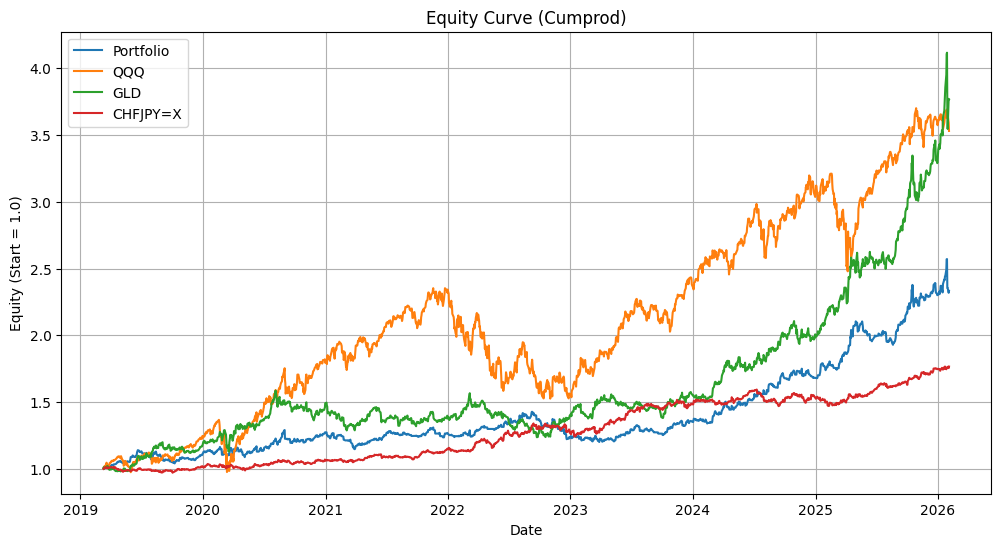

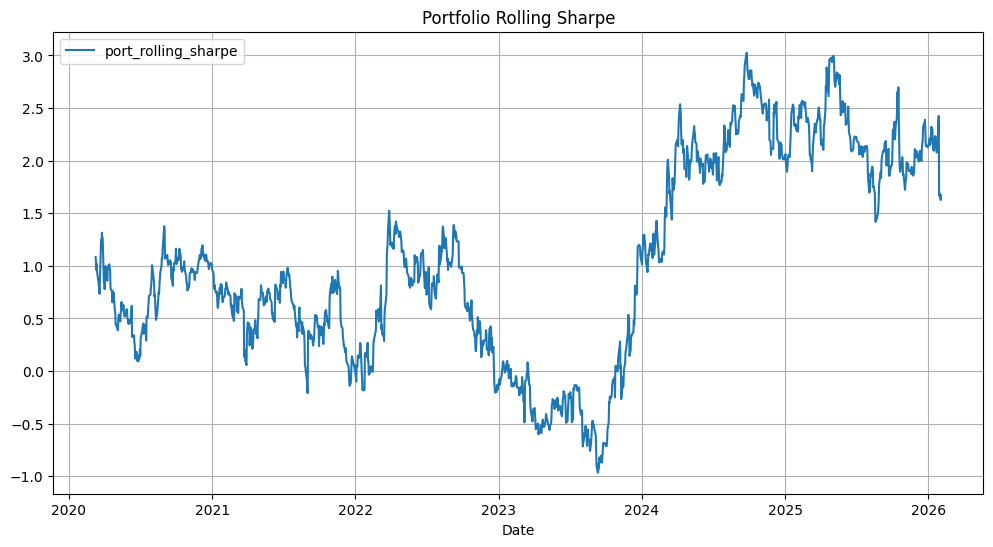

,mean,std,sharpe,sortino,max_dd
Portfolio,0.130535,0.121763,1.072047,1.517186,-0.158693
QQQ,0.212643,0.242273,0.877698,1.247741,-0.351187
GLD,0.206814,0.167564,1.234239,1.768318,-0.220022
CHFJPY=X,0.085616,0.077209,1.108885,1.626708,-0.077568


In [8]:
ret_df = hmm_weight(tickers, df)
cumprods, rolling_means, rolling_stds, rolling_sharpes, tot_means, tot_stds, tot_sharpes, tot_sortinos, max_dds = {}, {}, {}, {}, {}, {}, {}, {}, {}
port_cumprod, port_rolling_mean, port_rolling_std, port_rolling_sharpe, port_tot_mean, port_tot_std, port_tot_sharpe, port_tot_sortino, port_max_dd = overall_return_matrics(ret_df["port_oo"])
for ticker in tickers:
    cumprods[ticker], rolling_means[ticker], rolling_stds[ticker], rolling_sharpes[ticker], tot_means[ticker], tot_stds[ticker], tot_sharpes[ticker], tot_sortinos[ticker], max_dds[ticker] = overall_return_matrics(ret_df[f"{ticker}_oo"])

# -----------------------------
# 1) Equity curve (cumprod)
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(port_cumprod.index, port_cumprod.values, label="Portfolio")
for ticker in tickers:
    plt.plot(cumprods[ticker].index, cumprods[ticker].values, label=ticker)
plt.title("Equity Curve (Cumprod)")
plt.xlabel("Date")
plt.ylabel("Equity (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 2) Portfolio rolling sharpe
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(port_rolling_sharpe.index, port_rolling_sharpe.values, label="port_rolling_sharpe")
plt.title("Portfolio Rolling Sharpe")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 3) Summary table: mean / std / sharpe / max_dd
# -----------------------------
summary_df = pd.DataFrame({
        "mean":   [port_tot_mean]   + [tot_means[ticker]   for ticker in tickers],
        "std":    [port_tot_std]    + [tot_stds[ticker]    for ticker in tickers],
        "sharpe": [port_tot_sharpe] + [tot_sharpes[ticker] for ticker in tickers],
        "sortino":[port_tot_sortino]+ [tot_sortinos[ticker]for ticker in tickers],
        "max_dd": [port_max_dd]     + [max_dds[ticker]     for ticker in tickers],
    }, index=["Portfolio"] + list(tickers),
)

display(summary_df)
